<div style="text-align:center">
    <h2>Record Linkage</h2>
</div>


**Installing Requirements**

First of all, we need to install some libraries that are necessary for the solution of this project.

In [1]:
%%capture
!pip install numpy
!pip install pandas
!pip install nltk # Restart Kernel Required
!pip install spacy
!pip install scikit-learn
!pip install hdbscan
!pip install umap-learn

**Import Libraries**

Once we have installed the necessary libraries, we need to import them into the project.

In [3]:
# Libraries import
import pandas as pd
import nltk
import numpy as np
import string
import re
nltk.download("punkt")
import matplotlib.pyplot as plt

#Tokenization
import spacy
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

#Entity matching
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#Entity cluster
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
from sklearn.decomposition import PCA  # Import PCA
import hdbscan
from mpl_toolkits.mplot3d import Axes3D
import umap

#Making results reproducible
np.random.seed(100)

[nltk_data] Downloading package punkt to /Users/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Step 1: Data Cleaning

The idea of performing a data cleaning in an entity resolution proyect is to:
- Removing stop words.
- Tokenization of the documents/sentences or paragraphs.
- Things like casing, extra spaces, quotes and new lines can be ignored (not limited to that though).

**Most libraries that enable text vectorization already include these steps in their process. However, for better performance, we can define our own customizable process.**

In [4]:
def tokenizeData(text_attribute,tokenizer):
    
    if tokenizer=='nltk':
        tok_data=word_tokenize(text_attribute)
            
    elif tokenizer == 'spacy':
        py_nlp = English()
        py_tokenizer = Tokenizer(py_nlp.vocab)
        tok_data = [token.text for token in py_tokenizer(text_attribute)]

    elif tokenizer == 'custom':
        tok_data=re.findall(r'\b\w+\b|\d+|/',text_attribute)

    else:
        print("Select a valid tokenizer 'nltk' or 'spacy")

    return tok_data

def clean_stop_words(data):
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    lista = [word for word in data if word not in stop_words and word not in string.punctuation]
    return lista

def readData(input_filename):
    df_in = pd.read_csv(input_filename)
    return df_in

def writeDataToDisk(df_out,output_filename):
    df_out.to_csv(output_filename)
    return print(f"Document '{output_filename}' saved.")

**NLTK vs SPACY (ChatGPT 3.5)**
- If you prioritize speed and efficiency, especially in a production environment, spaCy might be a better choice.
- If you need fine-grained control over token boundaries and prefer explicit representation of punctuation, NLTK may be more suitable.
- For complex NLP tasks that require detailed linguistic annotations, spaCy's additional features might be beneficial.
- It's not uncommon to see researchers and practitioners use a combination of both libraries based on their specific needs for different tasks within a project.

### Step 2: Entity Matching

We define a function that receives two dataframe columns and return a matrix with cosine similarity between them.

In [5]:
def computeSimilarity(column1,column2):
    
    combined_documents = column1.to_list() + column2.to_list()

    # Create a TfidVectorizer with a custom tokenizer.
    vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenizeData(x, 'custom'))

    # Vectorize the list of variables.
    tfidf_matrix_combined = vectorizer.fit_transform(combined_documents)

    # Split the variables into individual matrices.
    num_documents_A = len(column1)
    tfidf_matrix_A = tfidf_matrix_combined[:num_documents_A]
    tfidf_matrix_B = tfidf_matrix_combined[num_documents_A:]

    # Compute cosine similarities between the two lists retA and retB title.
    cosine_similarities = cosine_similarity(tfidf_matrix_A, tfidf_matrix_B)

    # Create a DataFrame to store cosine similarities with corresponding indices.
    cosine_similarity_df = pd.DataFrame(cosine_similarities, index=column1, columns=column2)

    return cosine_similarity_df

### Step 3: Entity clustering

We define a function that receives a dataframe with numeric values that represent the distance between two variables

In [6]:
def entityClustering(dataframe):
    distance=1-dataframe
    # Apply PCA to reduce dimensionality to 3 components
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(distance)
    
    # Apply UMAP to reduce dimensionality to 3 components
    reducer = umap.UMAP(n_components=3)
    X_umap = reducer.fit_transform(distance)

    # Apply HDBSCAN clustering
    clusterer_def = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
    distance['cluster'] = clusterer_def.fit_predict(X_pca)
        
    # Add PCA components to DataFrame
    distance['X1'] = X_pca[:, 0]
    distance['X2'] = X_pca[:, 1]        
    distance['X3'] = X_pca[:, 1] 
    
    # Add UMAP components to DataFrame
    distance['Xmap_1'] = X_umap[:, 0]
    distance['Xmap_2'] = X_umap[:, 1]        
    distance['Xmap_3'] = X_umap[:, 1] 
    
    return distance

**Executing the algorithm**

Read the .csv files and apply the processes

In [7]:
retA=readData('retailerA.csv')
retB=readData('retailerB.csv')
df_cluster=entityClustering(computeSimilarity(retA['title'],retB['title']))

/Users/daniel/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


**Number of clusters obtained**

In [9]:
len(df_cluster['cluster'].unique())

152

**2-D clusters plot**

Using UMAP components

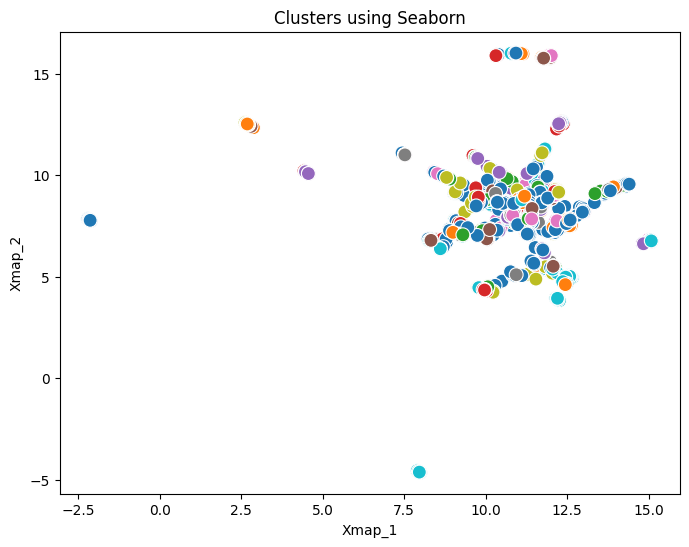

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Xmap_1', y='Xmap_2', hue='cluster', palette='tab10', data=df_cluster, s=100,legend=False)
plt.title('Clusters using Seaborn')
plt.show()

Using PCA components

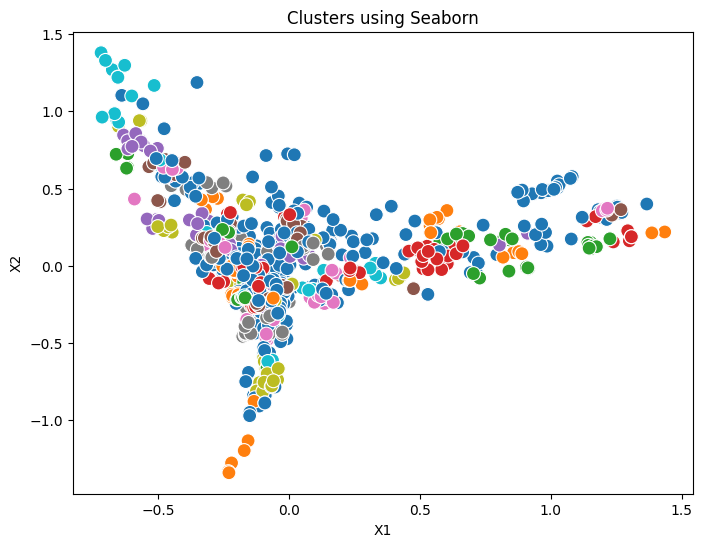

In [144]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='X1', y='X2', hue='cluster', palette='tab10', data=df_cluster, s=100,legend=False)
plt.title('Clusters using Seaborn')
plt.show()

**3-D clusters plot**

Usin UMAP components

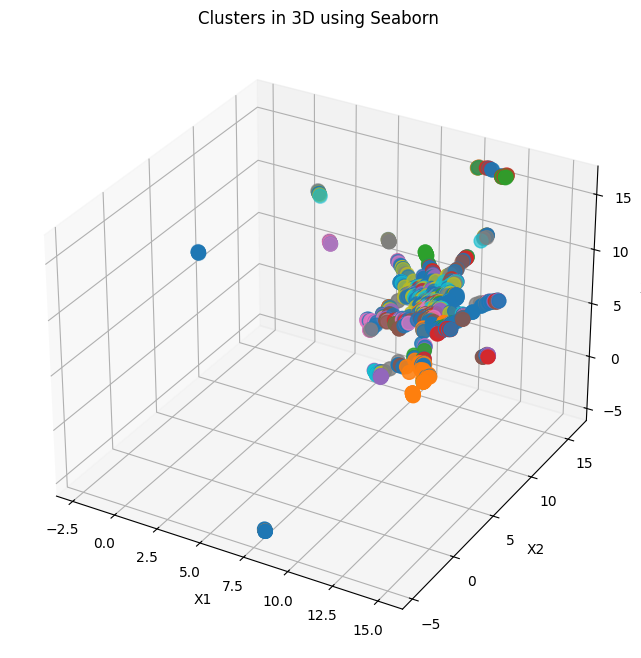

In [12]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

scatter = ax.scatter(df_cluster['Xmap_1'], df_cluster['Xmap_2'], df_cluster['Xmap_3'], c=df_cluster['cluster'], cmap='tab10', s=100)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Clusters in 3D using Seaborn')

plt.show()

Using PCA components

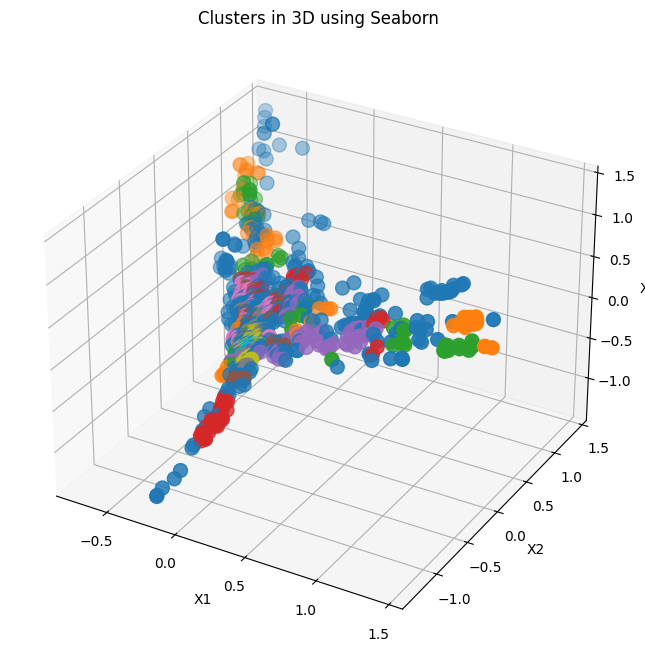

In [145]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

scatter = ax.scatter(df_cluster['X1'], df_cluster['X2'], df_cluster['X3'], c=df_cluster['cluster'], cmap='tab10', s=100)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Clusters in 3D using Seaborn')

plt.show()

**Examples of the samples clustering**

In [153]:
df_cluster[(df_cluster['cluster']==1)|(df_cluster['cluster']==2)][['cluster']].sort_values('cluster')

title,cluster
title,
LG 37' Black LCD Flat Panel HDTV - 37LG50,1
LG 32' Black LCD Flat Panel HDTV - 32LG30,1
LG 52' Black LCD Flat Panel HDTV - 52LG50,1
LG 47' Black LCD Flat Panel HDTV - 47LG50,1
LG 52' Black LCD Flat Panel HDTV - 52LG70,1
LG 42' Glossy Piano Black LCD Flat Panel HDTV - 42LG30,1
Panasonic Silver Dect 6.0 Cordless Telephone - KXTG1033S,2
Panasonic Black Dect 6.0 Cordless Telephone - KXTG9333T,2
Panasonic Expandable Bluetooth-Enabled DECT 6.0 Phone System - KXTH1212B,2
